In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd

In [5]:
# Cargar el archivo de logs para ver su contenido
file_path = 'nginx_logs'
with open(file_path, 'r') as file:
    log_data = file.readlines()

# Mostrar las primeras líneas del archivo para tener una idea de su estructura
log_data[:10]


['nginx-96-tw8hm nginx "IL" 46.19.86.154 - - [05/Mar/2023:21:52:04 +0000] "POST /tracking/tour_calendar_show_days HTTP/1.1" 200 2 "https://www.guruwalk.com/walks/46175-exploring-ancient-rome-free-walking-tour" "Mozilla/5.0 (iPhone; CPU iPhone OS 16_3 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) CriOS/110.0.5481.114 Mobile/15E148 Safari/604.1" "46.19.86.154, 172.69.130.123"\n',
 'nginx-96-tw8hm nginx "ES" 139.47.24.12 - - [05/Mar/2023:21:52:05 +0000] "GET /mobile/versions?device_os=ios HTTP/1.1" 200 39 "-" "Dart/2.16 (dart:io)" "139.47.24.12, 172.71.186.7"\n',
 'nginx-96-tw8hm nginx "-" 10.129.6.1 - - [05/Mar/2023:21:52:05 +0000] "GET /html/ HTTP/1.1" 200 615 "-" "kube-probe/1.24" "-"\n',
 'nginx-96-tw8hm nginx "FR" 178.20.49.15 - - [05/Mar/2023:21:52:05 +0000] "POST /es/bookings?psb=true HTTP/1.1" 302 1310 "https://www.guruwalk.com/es/walks/43167-free-tour-de-montmartre-el-apasionante-viaje-del-martirio-al-amor/how-do-free-tours-work" "Mozilla/5.0 (iPhone; CPU iPhone OS 16_0

Crear un Data Frame para organizar los datos principales en una tabla legible

In [6]:
# Expresión regular para extraer datos relevantes de los logs
log_pattern = re.compile(
    r'^(?P<server>[^ ]+) (?P<service>[^ ]+) "(?P<country>[^"]*)" (?P<ip>[^ ]+) - - \[(?P<datetime>[^\]]+)\] "(?P<method>[^ ]+) (?P<url>[^ ]+) (?P<protocol>[^"]+)" (?P<status>\d+) (?P<size>\d+) "(?P<referer>[^"]*)" "(?P<user_agent>[^"]+)" "(?P<client_ip>[^"]+)"$'
)

# Extraer datos de los logs usando la expresión regular
log_data_extracted = []
for line in log_data:
    match = log_pattern.match(line)
    if match:
        log_data_extracted.append(match.groupdict())

# Crear un DataFrame con los datos extraídos
df_logs = pd.DataFrame(log_data_extracted)

# Convertir 'datetime' a tipo datetime
df_logs['datetime'] = pd.to_datetime(df_logs['datetime'], format='%d/%b/%Y:%H:%M:%S %z')

# Mostrar las primeras filas del DataFrame
df_logs.head()


,server,service,country,ip,datetime,method,url,protocol,status,size,referer,user_agent,client_ip
0,nginx-96-tw8hm,nginx,IL,46.19.86.154,2023-03-05 21:52:04+00:00,POST,/tracking/tour_calendar_show_days,HTTP/1.1,200,2,https://www.guruwalk.com/walks/46175-exploring...,Mozilla/5.0 (iPhone; CPU iPhone OS 16_3 like M...,"46.19.86.154, 172.69.130.123"
1,nginx-96-tw8hm,nginx,ES,139.47.24.12,2023-03-05 21:52:05+00:00,GET,/mobile/versions?device_os=ios,HTTP/1.1,200,39,-,Dart/2.16 (dart:io),"139.47.24.12, 172.71.186.7"
2,nginx-96-tw8hm,nginx,-,10.129.6.1,2023-03-05 21:52:05+00:00,GET,/html/,HTTP/1.1,200,615,-,kube-probe/1.24,-
3,nginx-96-tw8hm,nginx,FR,178.20.49.15,2023-03-05 21:52:05+00:00,POST,/es/bookings?psb=true,HTTP/1.1,302,1310,https://www.guruwalk.com/es/walks/43167-free-t...,Mozilla/5.0 (iPhone; CPU iPhone OS 16_0_2 like...,"178.20.49.15, 172.71.130.49"
4,nginx-96-tw8hm,nginx,ES,82.158.111.202,2023-03-05 21:52:05+00:00,POST,/es/privacy_settings/cookies?ad_personalizatio...,HTTP/1.1,204,0,https://www.guruwalk.com/es/florencia,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"82.158.111.202, 172.68.134.77"


Identificar Bots vs Usuarios Reales

In [7]:
# Definir patrones comunes en los user agents de los bots
bot_patterns = ['bot', 'spider', 'crawl', 'probe', 'fetch', 'slurp', 'mediapartners', 'scanner', 'curl', 'wget']
googlebot_patterns = ['Googlebot', 'Mediapartners-Google', 'AdsBot-Google', 'APIs-Google']


# Crear una nueva columna 'is_bot' para marcar los bots
df_logs['is_bot'] = df_logs['user_agent'].str.contains('|'.join(bot_patterns), case=False, na=False)

# Crear una nueva columna 'is_google' para marcar solicitudes provenientes de Google
df_logs['is_google'] = df_logs['user_agent'].str.contains('|'.join(googlebot_patterns), case=False, na=False)


# Contar el número de accesos de bots, usuarios reales y solicitudes de Google
bot_count = df_logs['is_bot'].sum()
user_count = (~df_logs['is_bot']).sum()
google_count = df_logs['is_google'].sum()

bot_count, user_count, google_count


(np.int64(31442), np.int64(196788), np.int64(14299))

C:\Users\gabriel.hernan\AppData\Local\Temp\ipykernel_52044\1645779670.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(traffic_counts.keys()), y=list(traffic_counts.values()), palette='viridis')


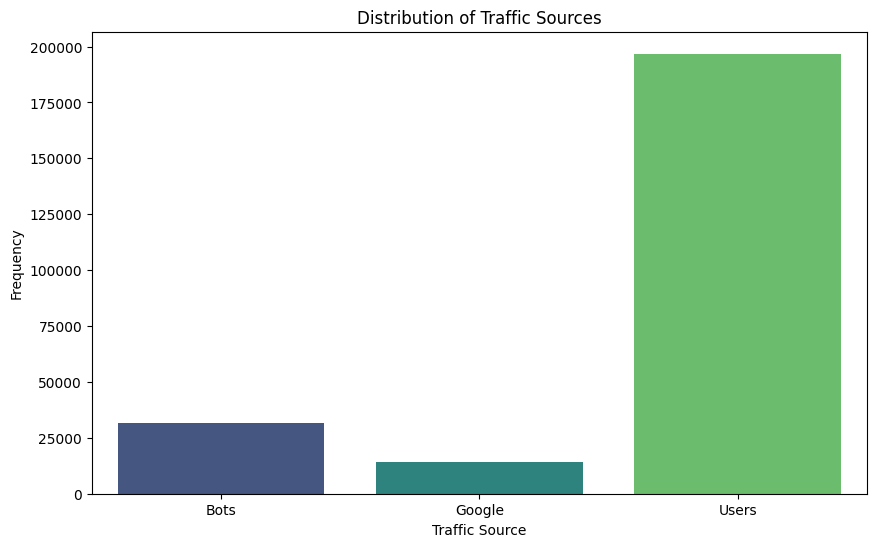

In [8]:
# Gráfico de Distribución del Tráfico de Bots, Google y Usuarios Reales
traffic_counts = {
    'Bots': bot_count,
    'Google': google_count,
    'Users': user_count
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(traffic_counts.keys()), y=list(traffic_counts.values()), palette='viridis')
plt.xlabel('Traffic Source')
plt.ylabel('Frequency')
plt.title('Distribution of Traffic Sources')
plt.show()

Análisis de los códigos de estado HTTP

In [9]:
# Contar la frecuencia de cada código de estado HTTP
status_counts = df_logs['status'].value_counts().sort_index()

In [10]:
status_counts

status
101      4955
200    170885
204     13863
301      7905
302     21550
304      3624
400         4
401       361
403         1
404      4162
406       110
422       788
499        12
500         9
504         1
Name: count, dtype: int64

C:\Users\gabriel.hernan\AppData\Local\Temp\ipykernel_52044\4240450064.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')


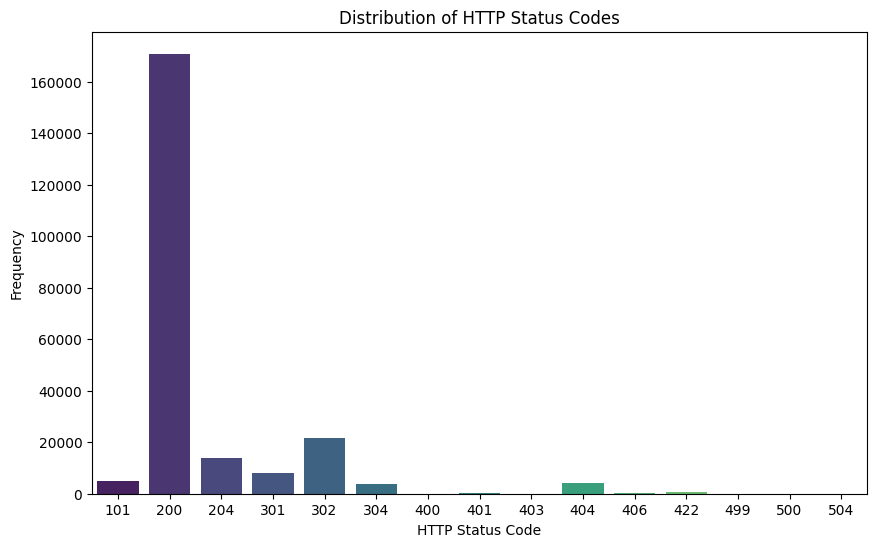

In [11]:
# Gráfico de Distribución de Códigos de Estado HTTP
plt.figure(figsize=(10, 6))
sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')
plt.xlabel('HTTP Status Code')
plt.ylabel('Frequency')
plt.title('Distribution of HTTP Status Codes')
plt.show()

Top Folders y Top Urls de Google Bot

In [12]:
# Filtrar las solicitudes realizadas por Googlebot
googlebot_requests = df_logs[df_logs['is_google']]

Identificación de la estructura de URLs del sitio

In [13]:
from urllib.parse import urlparse

# Función para extraer la carpeta principal
def extract_folder(url):
    parsed_url = urlparse(url)
    path_parts = parsed_url.path.split('/')
    if len(path_parts) > 1:
        return '/' + path_parts[1]
    return '/'

# Aplicar la función a las URLs
df_logs['folder'] = df_logs['url'].apply(extract_folder)

# Filtrar las solicitudes realizadas por Googlebot
googlebot_requests = df_logs[df_logs['is_google']]

# Contar la frecuencia de cada carpeta solicitada por Googlebot
top_googlebot_folders = googlebot_requests['folder'].value_counts().head(10)
print("Top Folders solicitadas por Googlebot:")
print(top_googlebot_folders)

# Contar la frecuencia de cada URL solicitada por Googlebot
top_googlebot_urls = googlebot_requests['url'].value_counts().head(10)
print("Top URLs solicitadas por Googlebot:")
print(top_googlebot_urls)


Top Folders solicitadas por Googlebot:
folder
/walks       3765
/es          3710
/de          1314
/it          1261
/tracking     407
/blog         376
/en-US         87
/api           74
/madrid        66
/gurus         63
Name: count, dtype: int64
Top URLs solicitadas por Googlebot:
url
/tracking/tour_card_views            362
/tracking/tour_calendar_show_days     45
/es                                   39
/                                     37
/it                                   21
/es/amberes                           12
/madrid                               12
/rome                                 12
/de                                   12
/es/budapest                          11
Name: count, dtype: int64


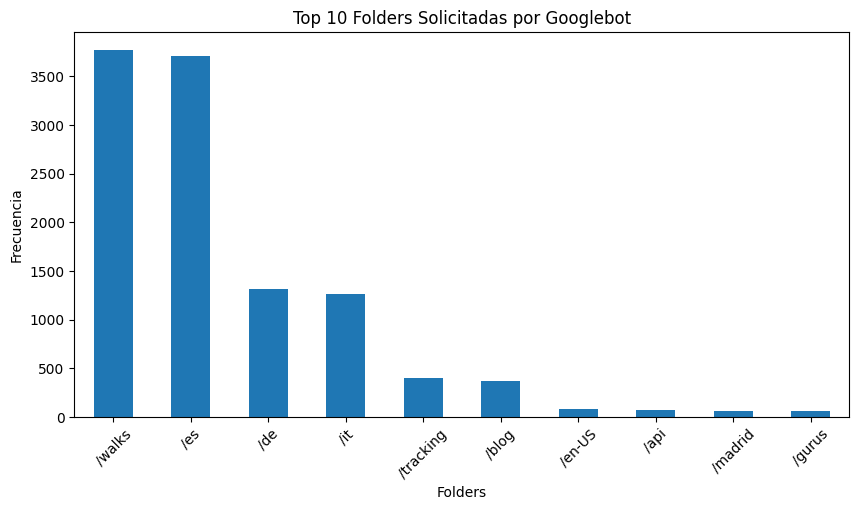

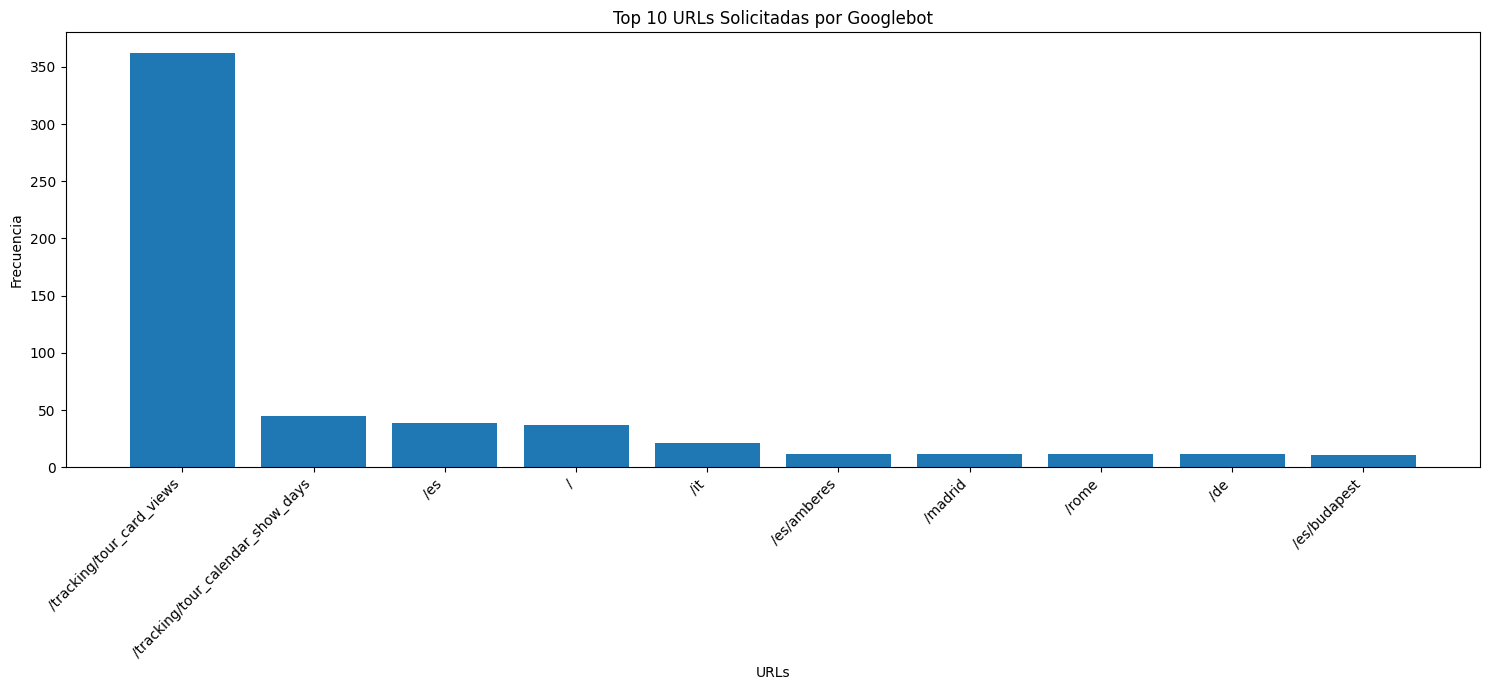

In [14]:
# Función para abreviar URLs largas
def abbreviate_url(url, max_length=50):
    if len(url) > max_length:
        return url[:max_length] + '...'
    return url

# Aplicar la función a las URLs para abreviarlas
top_googlebot_urls_abbreviated = top_googlebot_urls.index.to_series().apply(abbreviate_url)

# Top Folders solicitadas por Googlebot
top_googlebot_folders = googlebot_requests['folder'].value_counts().head(10)

# Top URLs solicitadas por Googlebot
top_googlebot_urls = googlebot_requests['url'].value_counts().head(10)

# Abreviar las URLs largas
top_googlebot_urls_abbreviated = top_googlebot_urls.index.to_series().apply(abbreviate_url)

# Gráfico de barras para Top Folders solicitadas por Googlebot
plt.figure(figsize=(10, 5))
top_googlebot_folders.plot(kind='bar')
plt.title('Top 10 Folders Solicitadas por Googlebot')
plt.xlabel('Folders')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras para Top URLs solicitadas por Googlebot con URLs abreviadas
plt.figure(figsize=(15, 7))
plt.bar(top_googlebot_urls_abbreviated, top_googlebot_urls)
plt.title('Top 10 URLs Solicitadas por Googlebot')
plt.xlabel('URLs')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [15]:
# Función para identificar si la URL solicita una imagen
def is_image(url, is_google):
    if is_google:
        image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp', '.svg']
        return 'image' if any(url.lower().endswith(ext) for ext in image_extensions) else 'non_image'
    return 'not_google'

In [16]:
# Función para identificar el tipo de dispositivo desde el user agent
def googlebot_type(user_agent, is_google):
    if is_google:
        if 'Googlebot-Mobile' in user_agent or 'Mobile' in user_agent:
            return 'mobile'
        elif 'Googlebot' in user_agent:
            return 'desktop'
    return 'not_google'

Frecuencia de tipos de dispositivos solicitados por Googlebot:
googlebot_type
mobile        8291
desktop       4754
not_google    1254
Name: count, dtype: int64
Frecuencia de solicitudes de imágenes por Googlebot:
is_image
non_image    14277
image           22
Name: count, dtype: int64


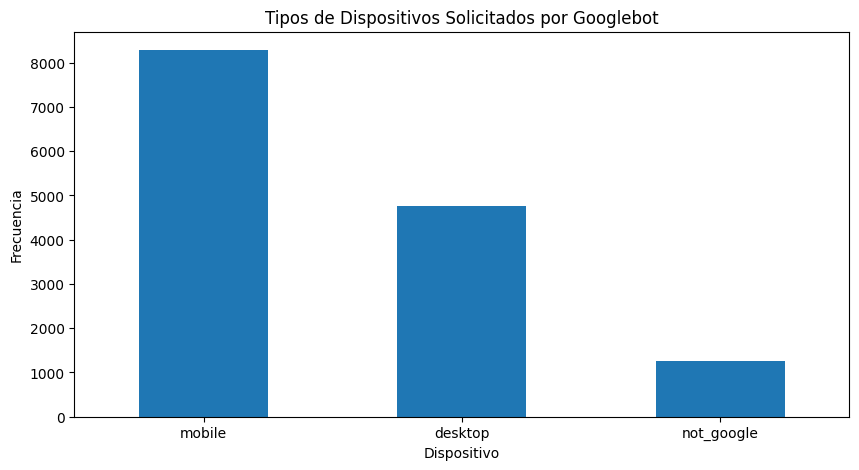

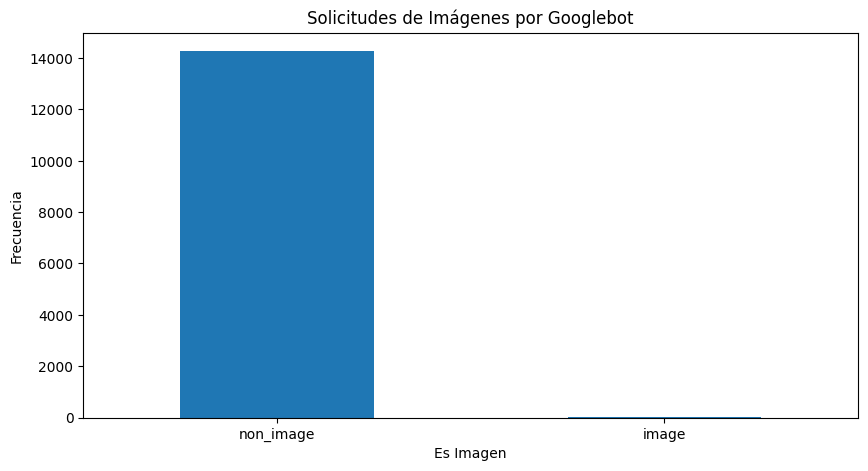

In [17]:
# Aplicar las funciones al DataFrame
df_logs['is_image'] = df_logs.apply(lambda row: is_image(row['url'], row['is_google']), axis=1)
df_logs['googlebot_type'] = df_logs.apply(lambda row: googlebot_type(row['user_agent'], row['is_google']), axis=1)


# Filtrar las solicitudes realizadas por Googlebot
googlebot_requests = df_logs[df_logs['is_google']]

# Contar la frecuencia de tipos de dispositivos
googlebot_device_counts = googlebot_requests['googlebot_type'].value_counts()

# Contar la frecuencia de solicitudes de imágenes
googlebot_image_counts = googlebot_requests['is_image'].value_counts()

# Mostrar los resultados
print("Frecuencia de tipos de dispositivos solicitados por Googlebot:")
print(googlebot_device_counts)

print("Frecuencia de solicitudes de imágenes por Googlebot:")
print(googlebot_image_counts)

# Gráfico de barras para tipos de dispositivos solicitados por Googlebot
plt.figure(figsize=(10, 5))
googlebot_device_counts.plot(kind='bar')
plt.title('Tipos de Dispositivos Solicitados por Googlebot')
plt.xlabel('Dispositivo')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.show()

# Gráfico de barras para solicitudes de imágenes por Googlebot
plt.figure(figsize=(10, 5))
googlebot_image_counts.plot(kind='bar')
plt.title('Solicitudes de Imágenes por Googlebot')
plt.xlabel('Es Imagen')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.show()